# Project: Online Payments Fraud Detection

This project addresses a binary classification task focused on detecting fraudulent online payment transactions. The dataset contains transactional and account-related information, aiming to distinguish between legitimate and fraudulent activities.

#### key features
    step: represents a unit of time where 1 step equals 1 hour
    type: type of online transaction
    amount: the amount of the transaction
    nameOrig: customer starting the transaction
    oldbalanceOrg: balance before the transaction
    newbalanceOrig: balance after the transaction
    nameDest: recipient of the transaction
    oldbalanceDest: initial balance of recipient before the transaction
    newbalanceDest: the new balance of recipient after the transaction
    isFraud: fraud transaction

You can get the dataset on Kaggle: 
https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

#### Workflow Overview

The notebook includes:
        Data exploration and cleaning
        Feature engineering
        Training and evaluation of two models: XGBoost and Random Forest
        Visualization of model performance and feature importance

#### Model Performance

Two machine learning models were trained to detect fraudulent transactions: XGBoost and Random Forest. Both performed well, but in slightly different ways.

XGBoost showed strong overall performance, especially in precision — meaning that when it predicted a transaction was fraudulent, it was usually correct. However, its recall was lower, which means it missed some fraudulent cases. Overall, it achieved a good balance, with a ROC-AUC score of 0.865, indicating reliable discrimination between fraud and non-fraud.
    
Random Forest achieved even better results in terms of overall discrimination, with a ROC-AUC of 0.999. It also had a precision of 0.91 and a recall of 0.77, meaning it was both accurate and relatively complete in catching fraud cases.

The two models also revealed different insights about what matters most for detecting fraud.
For Random Forest, the most important signals came from the balance changes — specifically, how the sender’s and recipient’s balances changed during the transaction.
For XGBoost, the transaction amount stood out as the strongest indicator of fraud.

These findings suggest that fraud detection can benefit from both the size of a transaction and the patterns of money movement between accounts.

## Data overview

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn import metrics
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve

In [2]:
data = pd.read_csv('Online Payments Fraud Detection Dataset.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data.shape

(6362620, 11)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [5]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
data.describe().style.background_gradient(cmap='PuBuGn')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.000000,6362620.000000,6362620.000000,6362620.000000,6362620.000000,6362620.000000,6362620.000000,6362620.000000
mean,243.397246,179861.903549,833883.104074,855113.668579,1100701.666520,1224996.398202,0.001291,0.000003
std,142.331971,603858.231463,2888242.673007,2924048.502971,3399180.112969,3674128.942094,0.035905,0.001586
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,156.000000,13389.570000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,239.000000,74871.940000,14208.000000,0.000000,132705.665000,214661.440000,0.000000,0.000000
75%,335.000000,208721.477500,107315.175000,144258.410000,943036.707500,1111909.250000,0.000000,0.000000
max,743.000000,92445516.640000,59585040.370000,49585040.370000,356015889.350000,356179278.920000,1.000000,1.000000


In [7]:
print(data['isFraud'].value_counts())

isFraud
0    6354407
1       8213
Name: count, dtype: int64


data['type'].nunique()

## Exploratory Data Analysis (EDA)

In [8]:
data.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


#### What kinds of transactions are most common?

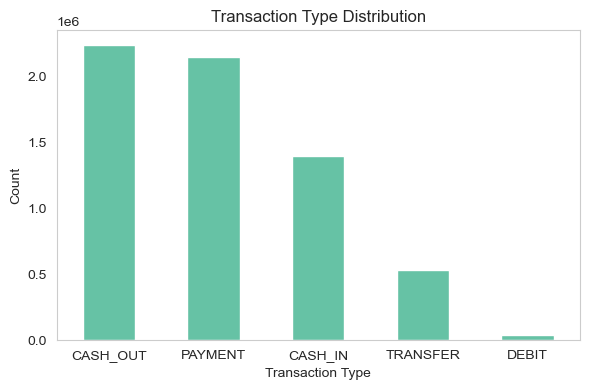

In [9]:
sns.set_style('whitegrid')
sns.set_palette('Set2')

data['type'].value_counts().plot(kind='bar', title='Transaction Type Distribution', figsize=(6, 4))
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.grid(False)
plt.show()

#### How many unique users were involved in fraud?

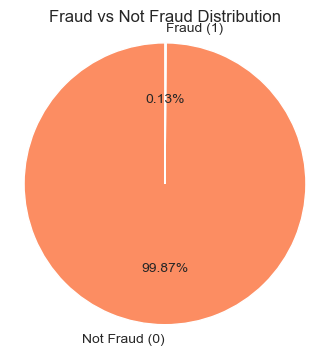

In [10]:
fraud_counts = data['isFraud'].value_counts()
labels = ['Not Fraud (0)', 'Fraud (1)']
colors = sns.color_palette('Set2')[1:3]

plt.figure(figsize=(4, 4))
plt.pie(fraud_counts, labels=labels, autopct='%1.2f%%', startangle=90, colors=colors)
plt.title('Fraud vs Not Fraud Distribution')
plt.axis('equal') 
plt.show()

#### At what times does fraud most often occur?

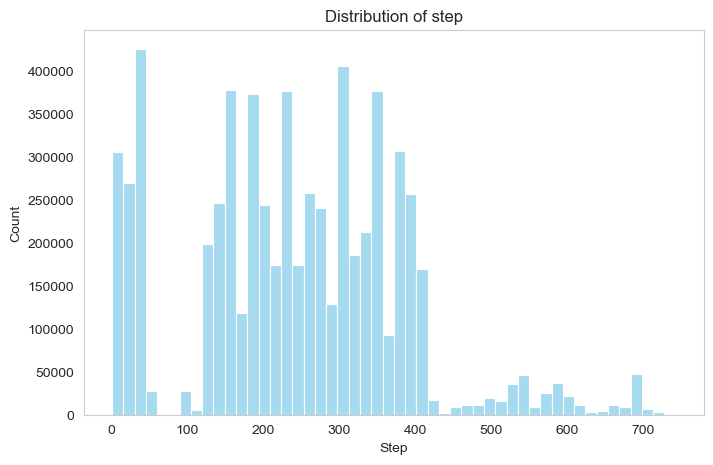

In [11]:
plt.figure(figsize=(8, 5))
sns.histplot(data['step'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of step')
plt.xlabel('Step')
plt.ylabel('Count')
plt.grid(False)
plt.show()

The 'step' variable represents a continuous count of hours without clear periodicity or meaningful distribution.
Since it does not reflect a real temporal pattern (e.g., daily cycles) and lacks interpretability,
including it as a feature may introduce noise or misleading trends in the model.
Therefore, 'step' is excluded from the feature set in the current analysis.

#### How do old and new balances relate across different transaction types and fraud status?

In [12]:
data['log_amount'] = np.log1p(data['amount'])
data['log_oldbalanceOrg'] = np.log1p(data['oldbalanceOrg'])
data['log_newbalanceOrig'] = np.log1p(data['newbalanceOrig'])
data['log_oldbalanceDest'] = np.log1p(data['oldbalanceDest'])
data['log_newbalanceDest'] = np.log1p(data['newbalanceDest'])

features_log = ['log_oldbalanceOrg', 'log_newbalanceOrig', 'log_oldbalanceDest', 'log_newbalanceDest']

We take the logarithm of amount and balance values because these numbers vary a lot — from very small to very large. 
Log transformation helps reduce this wide range, making patterns easier to see and analyze.
We add 1 before taking log to avoid problems with zero values, since log(0) log(0) is undefined.

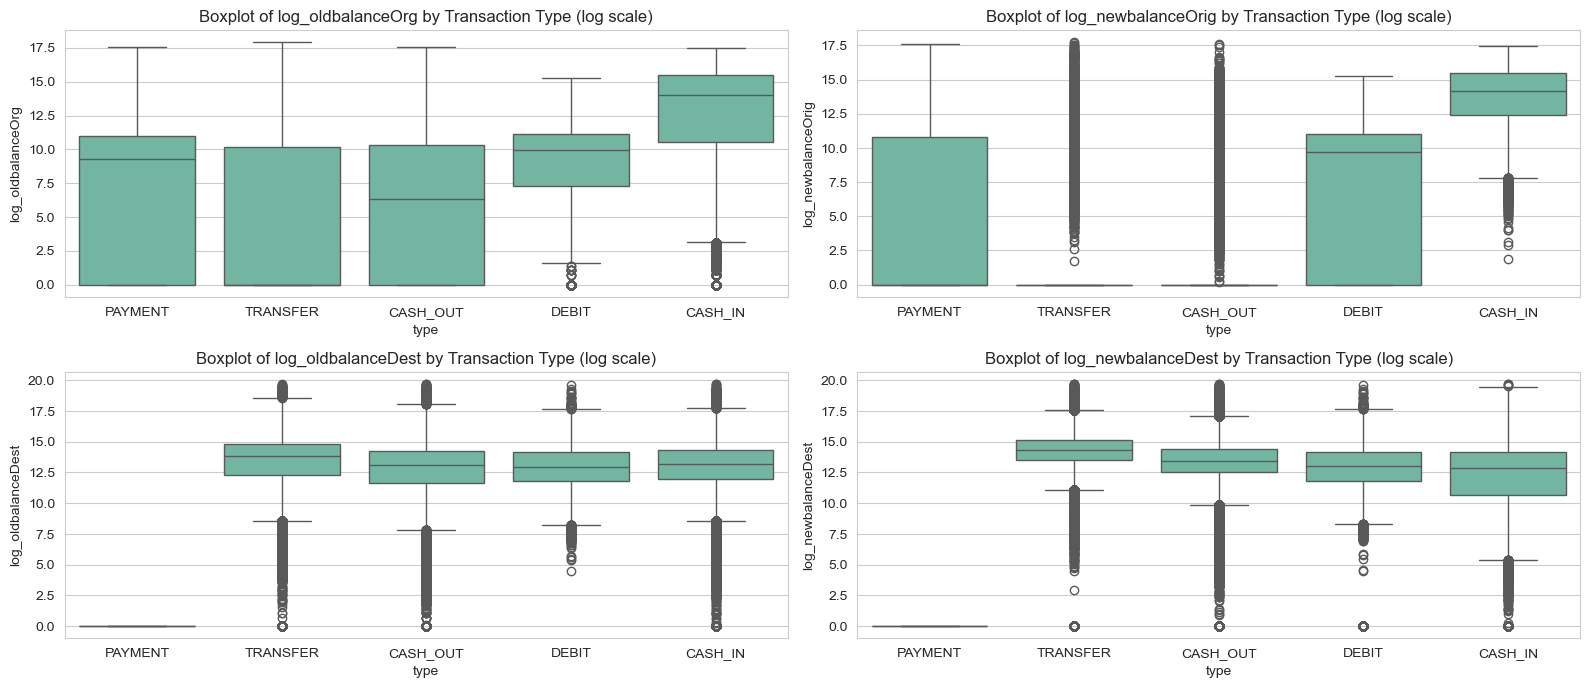

In [13]:
sns.set_palette('Set2')

plt.figure(figsize=(16, 10))
for i, feature in enumerate(features_log, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='type', y=feature, data=data)
    plt.title(f'Boxplot of {feature} by Transaction Type (log scale)')
    plt.xticks(rotation=0)

plt.tight_layout()
plt.show()

#### What is the relationship between transaction amounts by type and fraud status?

In [14]:
# Calculate the total transaction amount for each 'type' and 'isFraud' status
# pd.crosstab creates a table that aggregates 'amount' sums grouped by 'type' and 'isFraud'
cross_tab = pd.crosstab(data['type'], data['isFraud'], values=data['amount'], aggfunc='sum').fillna(0)

# Rename columns for better readability
cross_tab.columns = ['Non-Fraud', 'Fraud']

# Display the resulting table
print(cross_tab)

             Non-Fraud         Fraud
type                                
CASH_IN   2.363674e+11  0.000000e+00
CASH_OUT  3.884238e+11  5.989202e+09
DEBIT     2.271992e+08  0.000000e+00
PAYMENT   2.809337e+10  0.000000e+00
TRANSFER  4.792248e+11  6.067213e+09


The majority of transaction amounts for all types are classified as Non-Fraud.
CASH_OUT and TRANSFER types have noticeable fraud amounts, with fraud totaling approximately 6 billion for each.
Other transaction types such as CASH_IN, DEBIT, and PAYMENT show no recorded fraud amounts in this data.
The total amounts involved in Non-Fraud transactions are substantially larger than those in Fraud across all types.
This indicates that while fraud exists primarily in CASH_OUT and TRANSFER, it represents a relatively small fraction compared to overall transaction volumes.

#### What is the relation between old and new balances for different transaction types?

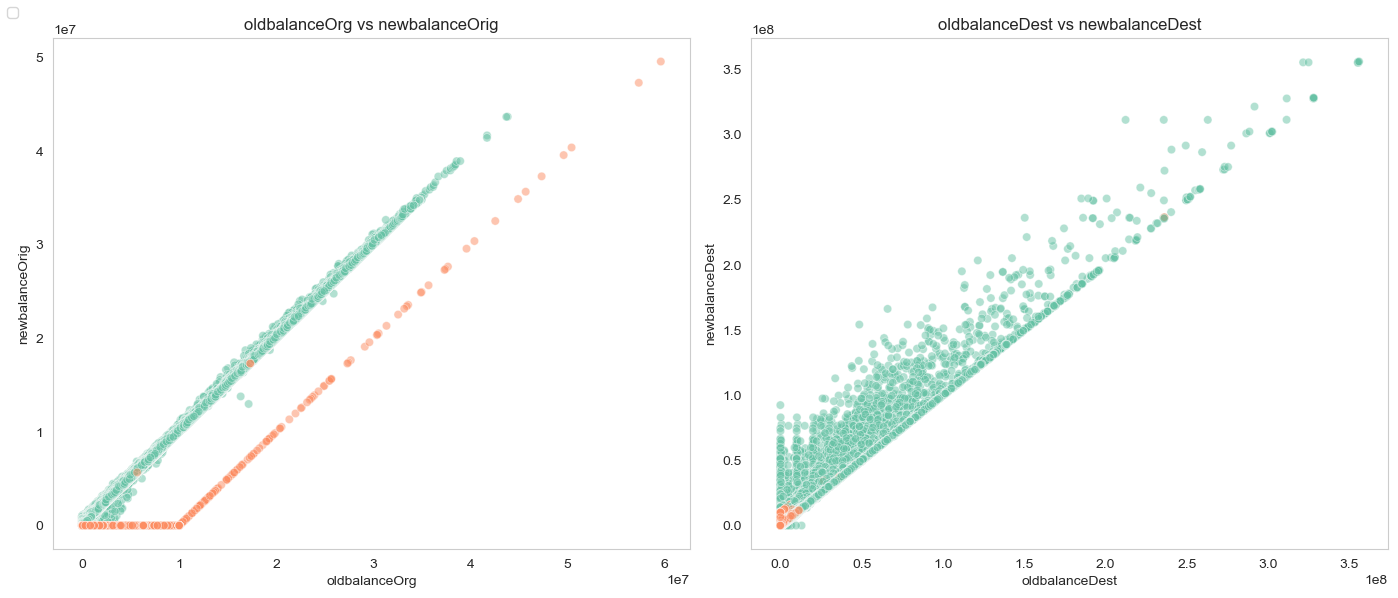

In [15]:
colors = sns.color_palette('Set2', 2)  

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# oldbalanceOrg vs newbalanceOrig with fraud hue and Set2 colors
sns.scatterplot(
    x='oldbalanceOrg', y='newbalanceOrig', data=data,
    alpha=0.5, hue='isFraud', palette={0: colors[0], 1: colors[1]}, ax=axes[0],
    legend=False  
)
axes[0].set_title('oldbalanceOrg vs newbalanceOrig')
axes[0].set_xlabel('oldbalanceOrg')
axes[0].set_ylabel('newbalanceOrig')
axes[0].grid(False)

# oldbalanceDest vs newbalanceDest with fraud hue and Set2 colors
sns.scatterplot(
    x='oldbalanceDest', y='newbalanceDest', data=data,
    alpha=0.5, hue='isFraud', palette={0: colors[0], 1: colors[1]}, ax=axes[1],
    legend=False  
)
axes[1].set_title('oldbalanceDest vs newbalanceDest')
axes[1].set_xlabel('oldbalanceDest')
axes[1].set_ylabel('newbalanceDest')
axes[1].grid(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.show()

#### How transaction amount relates to balance change?

In [16]:
data['Difference_Orig'] = data['oldbalanceOrg'] - data['newbalanceOrig'] 
data['Difference_Dest'] = data['newbalanceDest'] - data['oldbalanceDest'] 

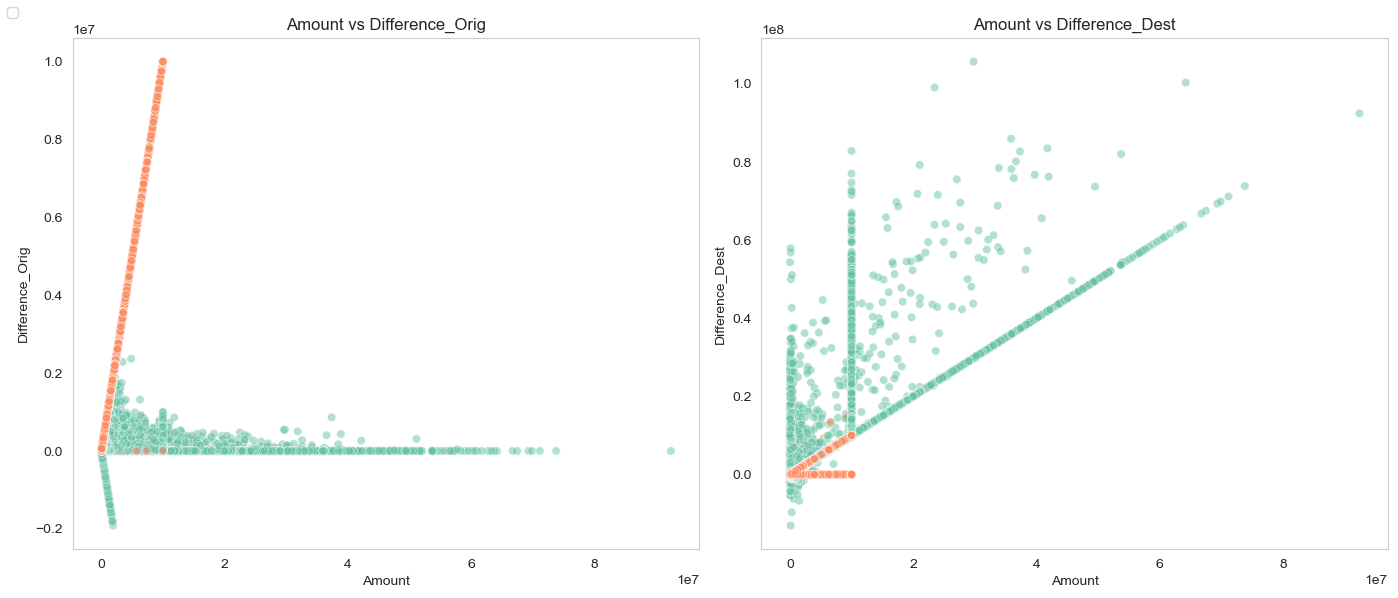

In [17]:
colors = sns.color_palette('Set2', 2)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# amount vs Difference_Orig with hue
sns.scatterplot(
    x='amount', y='Difference_Orig', data=data, alpha=0.5,
    hue='isFraud', palette={0: colors[0], 1: colors[1]}, ax=axes[0],
    legend=False
)
axes[0].set_title('Amount vs Difference_Orig')
axes[0].set_xlabel('Amount')
axes[0].set_ylabel('Difference_Orig')
axes[0].grid(False)

# amount vs Difference_Dest with hue
sns.scatterplot(
    x='amount', y='Difference_Dest', data=data, alpha=0.5,
    hue='isFraud', palette={0: colors[0], 1: colors[1]}, ax=axes[1],
    legend=False
)
axes[1].set_title('Amount vs Difference_Dest')
axes[1].set_xlabel('Amount')
axes[1].set_ylabel('Difference_Dest')
axes[1].grid(False)

# Add unified legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')

plt.tight_layout()
plt.show()

## Feature engineering

In [18]:
le = LabelEncoder()
data['type_encoded'] = le.fit_transform(data['type'])

## train-test split

In [19]:
features = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
            'newbalanceDest', 'Difference_Orig', 'Difference_Dest', 'type_encoded']
target = 'isFraud'

In [20]:
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## XGBoost classifier

In [21]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1) 

In [22]:
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [23]:
y_pred = xgb_clf.predict(X_test) 
y_pred_proba = xgb_clf.predict_proba(X_test)[:, 1]

In [24]:
print(classification_report(y_test, y_pred)) 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.98      0.73      0.84      2464

    accuracy                           1.00   1908786
   macro avg       0.99      0.87      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



In [25]:
print("ROC-AUC Score:", roc_auc_score(y_test,y_pred))

ROC-AUC Score: 0.8652495111379026


In [26]:
print("accuracy:",accuracy_score(y_test,y_pred))

accuracy: 0.9996317030824828


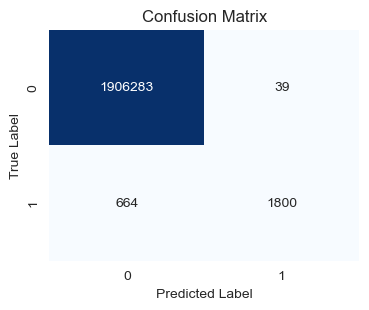

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

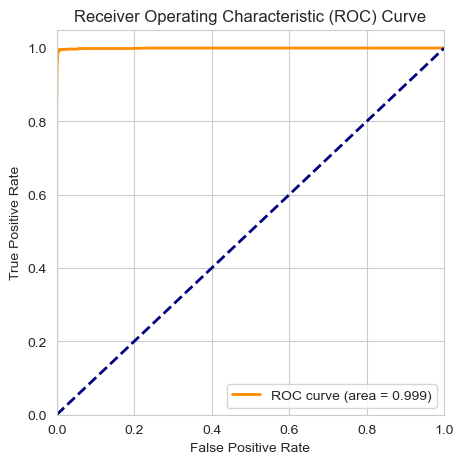

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

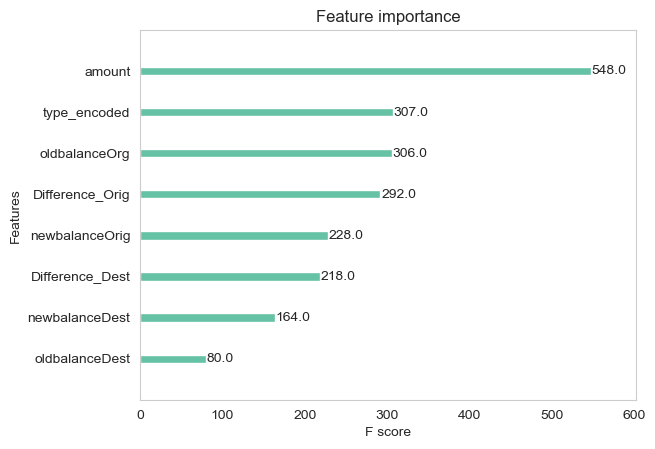

In [29]:
plot_importance(xgb_clf) 
plt.grid(False)
plt.show()

## Random forest classifier

In [30]:
# Train a Random Forest model with class balancing to handle imbalanced dataset
rf_clf = RandomForestClassifier(
    n_estimators=100,        # Number of trees in the forest
    max_depth=10,            # Limit the depth of each tree to reduce overfitting
    random_state=42,
    class_weight='balanced'  # Automatically adjust weights for imbalanced classes
)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

In [31]:
# Predict class labels and probabilities for the test set
y_pred = rf_clf.predict(X_test)
y_pred_proba = rf_clf.predict_proba(X_test)[:, 1]  # Probability of the positive class (fraud)

In [32]:
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

ROC AUC: 0.9992017054766521


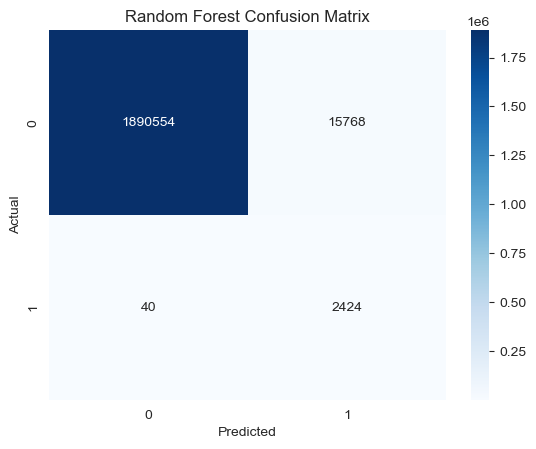

In [33]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

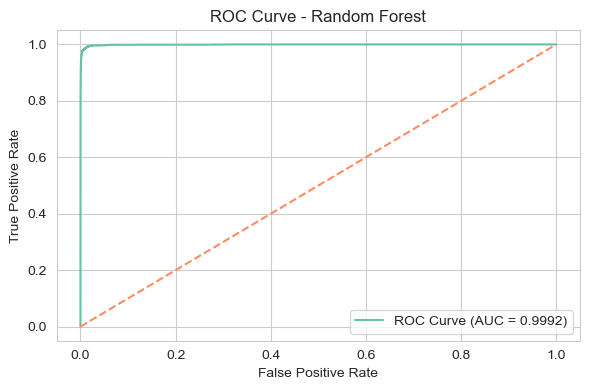

In [34]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')  # Reference line for random guessing
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

##### # Identify the threshold that yields the highest F1 score

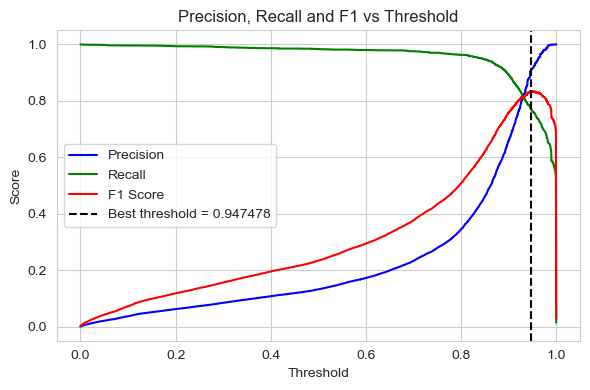

In [35]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

precision = precision[:-1]
recall = recall[:-1]

# calculate F1 score
f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

# Find the maximum F1 score and the corresponding threshold
best_idx = np.argmax(f1)
best_threshold = thresholds[best_idx]
max_f1 = f1[best_idx]

plt.figure(figsize=(6, 4))
plt.plot(thresholds, precision, label='Precision', color='blue')
plt.plot(thresholds, recall, label='Recall', color='green')
plt.plot(thresholds, f1, label='F1 Score', color='red')
plt.axvline(best_threshold, linestyle='--', color='black', label=f'Best threshold = {best_threshold:.6f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall and F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
print(f'Best threshold: {best_threshold}')
print(f'Max F1 Score: {max_f1:.4f}')

Best threshold: 0.9474777881028951
Max F1 Score: 0.8350


In [37]:
# Make classification predictions using the best threshold
best_threshold = 0.9474777881028951
y_pred_threshold = (y_pred_proba >= best_threshold).astype(int)

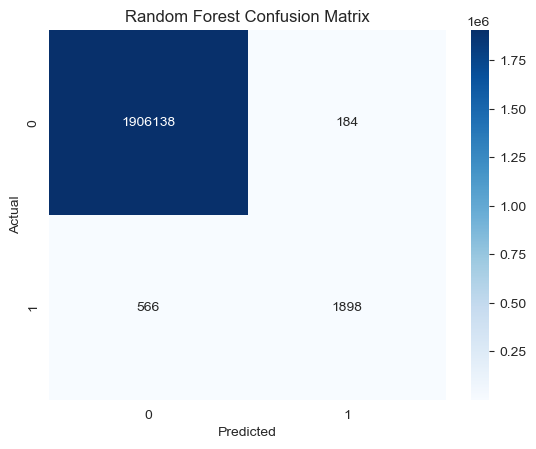

In [38]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_threshold)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [39]:
# Output the classification report
report = classification_report(y_test, y_pred_threshold)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906322
           1       0.91      0.77      0.84      2464

    accuracy                           1.00   1908786
   macro avg       0.96      0.89      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



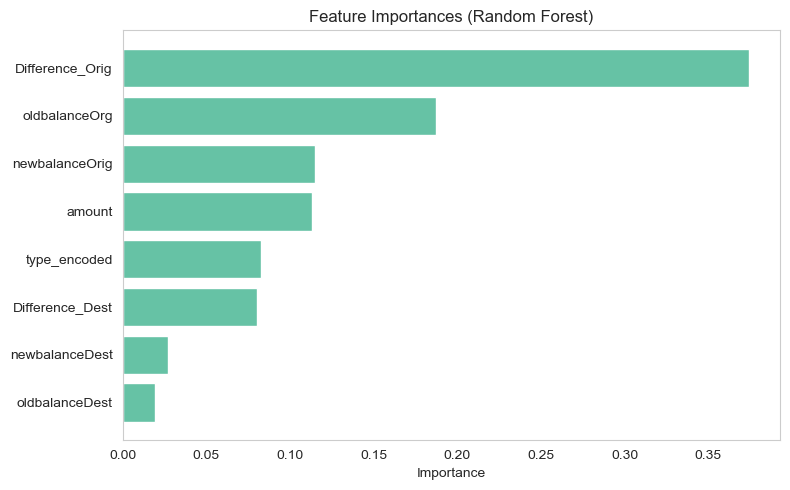

In [40]:
importances = rf_clf.feature_importances_
feature_names = X_train.columns  # 如果 X_train 是 DataFrame

# Get sorted indices
indices = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(range(len(importances)), importances[indices], align='center')
plt.yticks(range(len(importances)), feature_names[indices])
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.grid(False)
plt.show()